# Density Profile and IFT of mixture of Water + Butanol + MTBE

First it's needed to import the necessary modules

In [1]:
import numpy as np
from SGTPy import component, mixture, saftvrmie
from SGTPy.equilibrium import vlle, lle_init, tpd_min
from SGTPy.sgt import sgt_mix
import matplotlib.pyplot as plt 

The ternary mixture is created and then the interactions parameters are set. As MTBE can associate with Water and Butanol, this site/site interaction are set up manually modifying the ```eos.eABij``` and ```eos.rcij``` arrays. Finally, the $\beta_{ij}$ corrections are set.

In [2]:
import numpy as np
from SGTPy import component, mixture, saftvrmie

water = component('water', ms = 1.7311, sigma = 2.4539 , eps = 110.85,
                    lambda_r = 8.308, lambda_a = 6.,  eAB = 1991.07, rcAB = 0.5624,
                    rdAB = 0.4, sites = [0,2,2], cii = 1.5371939421515455e-20)

butanol = component('butanol2C', ms = 1.9651, sigma = 4.1077 , eps = 277.892,
                    lambda_r = 10.6689, lambda_a = 6., eAB = 3300.0, rcAB = 0.2615,
                    rdAB = 0.4, sites = [1,0,1], npol = 1.45, mupol = 1.6609,
                    cii  = 1.5018715324070352e-19)

mtbe = component('mtbe', ms =2.17847383,  sigma=  4.19140014, eps =  306.52083841,
                 lambda_r = 14.74135198, lambda_a = 6.0, npol = 2.95094686,  
                 mupol = 1.3611, sites = [0,0,1], cii =3.5779968517655445e-19 )

mix = mixture(water, butanol)
mix.add_component(mtbe)

#butanol water
k12, l12 = np.array([-0.00736075, -0.00737153])

#mtbe butanol
k23 = -0.0029995
l23 = 0.
rc23 =  1.90982649

#mtbe water
k13 = -0.07331438
l13 = 0.
rc13 = 2.84367922

# setting up interaction corrections
Kij = np.array([[0., k12, k13], [k12, 0., k23], [k13, k23, 0.]])
Lij = np.array([[0., l12, l13], [l12, 0., l23], [l13, l23, 0.]])
mix.kij_saft(Kij)
mix.lij_saft(Lij)
eos = saftvrmie(mix)

# setting up induced association
#mtbe water
eos.eABij[0,2] = water.eAB / 2
eos.eABij[2,0] = water.eAB / 2
eos.rcij[0,2] = rc13 * 1e-10
eos.rcij[2,0] = rc13 * 1e-10
#mtbe butanol
eos.eABij[2,1] = butanol.eAB / 2
eos.eABij[1,2] = butanol.eAB / 2
eos.rcij[2,1] = rc23 * 1e-10
eos.rcij[1,2] = rc23 * 1e-10

# optimized betas for SGT
b12 = 0.0
b13 = 0.05184890369269403
b23 = 0.1031045671358926

beta = np.array([[0., b12, b13], [b12, 0., b23], [b13, b23, 0.]])
eos.beta_sgt(beta)

The three phase equilibrium is computed with the ```vlle``` function. Initial guesses for the phase composition can be supplied for the user or by minimizing the tangent plane distance with the ```tpd_min``` function.

In [3]:
T = 345. #K
P = 1.01325e5 # Pa
#global composition
z = np.array([0.5, 0.3, 0.2])

# initial guess are computed with tpd minimization
x0, tpdx  = tpd_min(np.array([0.9, 0.05, 0.05]), z, T, P, eos, stateW='L', stateZ='L')
w0, tpdw = tpd_min(np.array([0.45, 0.45, 0.1]), z, T, P, eos, stateW='L', stateZ='L')
y0, tpdy = tpd_min(np.array([0.33, 0.33, 0.33]), z, T, P, eos,  stateW='V', stateZ='L')
tpdx, tpdw, tpdy # negative values implies a phase separation, zero are trivial solutions

(-0.08071753836051454, 4.5008441418303846e-13, -0.24043523824139323)

In [4]:
sol = vlle(x0, w0, y0, z, T, P, eos, full_output = True)
#reading the solution information
X, W, Y = sol.X
vx, vw, vy = sol.v
# computing density vectors 
rhox = X/vx
rhow = W/vw
rhoy = Y/vy

The equilibrium results are used in SGT with the ```sgt_mix``` function.

In [5]:
#solving density profiles for organic - vapor interface
solwy = sgt_mix(rhoy, rhow, T, P, eos, rho0 = 'hyperbolic', z0 = 15., dz = 0, full_output = True)

In [6]:
#solving density profiles for organic - aqueous interface
solxw = sgt_mix(rhow, rhox, T, P, eos, rho0 = 'hyperbolic', z0 = 15., dz = 0, full_output = True)

By default, the ```sgt_mix``` function uses linear or hyperbolic like density profiles as initial guesses. These options work well for most scenarios, as for the organic-vapor and the organic-aquaous interfaces. 

For the vapor-aqueous density profiles a better initial guess is necessary, this can be done by joining the two previous solutions and interpolating then at the desired grid.

In [7]:
# Vapor aqueous density profiles are trickier to solve, a better initial guess is needed.

from SGTPy import gauss
from scipy.interpolate import interp1d

# reading the density profiles from the previous calculations
zwy = solwy.z
zxw = solxw.z
rxw = solxw.rho
rwy = solwy.rho
# joining the density profiles
zxys = np.hstack([zwy[0:-1], zxw + zwy[-1]])
rxys = np.hstack([rwy[:, 0:-1], rxw[:, :]])
nroots = 30
#generating nodes to interpolate the density profile
roots, weights = gauss(nroots)
zinter = 30.*roots
#interpolate the density profile
rinter = interp1d(zxys, rxys, kind= 'cubic')(zinter)
#solving the densit profile using the generated profile as initial guess
solxy = sgt_mix(rhoy, rhox, T, P, eos, n = nroots, rho0 = rinter, z0 = 30., dz = 0, full_output = True)

Text(0.5, 1.0, '(c) L$_1$-L$_2$')

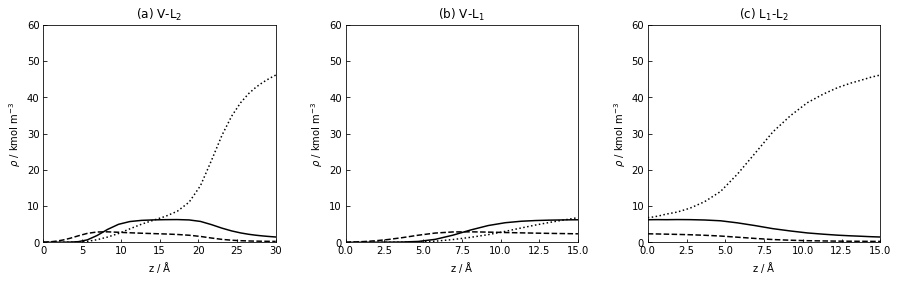

In [8]:
zxy = solxy.z
rxy = solxy.rho / 1000

zwy = solwy.z
rwy = solwy.rho / 1000

zxw = solxw.z
rxw = solxw.rho / 1000

fig = plt.figure(figsize = (15, 4))
fig.subplots_adjust(wspace = 0.3)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)


ax2.plot(zwy, rwy[0], ':', color = 'k')
ax2.plot(zwy, rwy[1], color = 'k')
ax2.plot(zwy, rwy[2], '--',color = 'k')

ax1.plot(zxy, rxy[0], ':', color = 'k')
ax1.plot(zxy, rxy[1], color = 'k')
ax1.plot(zxy, rxy[2], '--',color = 'k')

ax3.plot(zxw, rxw[0], ':', color = 'k')
ax3.plot(zxw, rxw[1], color = 'k')
ax3.plot(zxw, rxw[2], '--',color = 'k')

ax1.set_ylim([0, 60])
ax2.set_ylim([0, 60])
ax3.set_ylim([0, 60])

ax1.set_xlim([0, 30])
ax2.set_xlim([0, 15])
ax3.set_xlim([0, 15])

ax1.tick_params(direction = 'in')
ax2.tick_params(direction = 'in')
ax3.tick_params(direction = 'in')

ax1.set_ylabel(r'$\rho$ / kmol m$^{-3}$')
ax2.set_ylabel(r'$\rho$ / kmol m$^{-3}$')
ax3.set_ylabel(r'$\rho$ / kmol m$^{-3}$')

ax1.set_xlabel(r'z / $\rm \AA$')
ax2.set_xlabel(r'z / $\rm \AA$')
ax3.set_xlabel(r'z / $\rm \AA$')

ax1.set_title(r'(a) V-L$_2$')
ax2.set_title(r'(b) V-L$_1$')
ax3.set_title(r'(c) L$_1$-L$_2$')
